# 🌡️ 02 - Real-World Temperature Forecasting using Bayesian LSTM

This notebook loads a historical temperature dataset (Melbourne), trains a Bayesian LSTM, and forecasts the next-day minimum temperature with uncertainty estimation.

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np

# Load and scale data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=['Date'])
temps = df['Temp'].values.reshape(-1, 1)

scaler = MinMaxScaler()
temps_scaled = scaler.fit_transform(temps)

# Create sequence windows
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 30
X_real, y_real = create_sequences(temps_scaled, seq_len)

X_real_tensor = torch.tensor(X_real, dtype=torch.float32)       # shape: [N, 30, 1]
X_real_tensor = X_real_tensor.unsqueeze(-1) if X_real_tensor.ndim == 2 else X_real_tensor
y_real_tensor = torch.tensor(y_real, dtype=torch.float32)       # shape: [N]

# Train-test split
train_X, test_X = X_real_tensor[:3000], X_real_tensor[3000:]
train_y, test_y = y_real_tensor[:3000], y_real_tensor[3000:]

In [9]:
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=64, shuffle=True)

model = BayesianLSTM(input_size=1, hidden_size=32, output_size=1, dropout_rate=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

model.train()
for epoch in range(20):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb).squeeze()
        loss = loss_fn(output, yb)
        loss.backward()
        optimizer.step()

C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([56, 1])) that is different to the input size (torch.Size([56])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [10]:
def vectorized_mc_dropout_predict(model, x, T=100):
    model.train()  # Enable dropout at test time
    B, S, F = x.shape
    x_repeat = x.repeat(T, 1, 1)  # Shape: (T*B, S, F)

    with torch.no_grad():
        y_hat = model(x_repeat)  # Shape: (T*B, output_size)
    y_hat = y_hat.view(T, B, -1)  # Reshape to (T, B, output_size)

    mean = y_hat.mean(dim=0)  # Shape: (B, output_size)
    std = y_hat.std(dim=0)    # Shape: (B, output_size)
    return mean.cpu().numpy(), std.cpu().numpy()

In [13]:
# Predict with MC Dropout
model.eval()
mean_preds, std_preds = vectorized_mc_dropout_predict(model, test_X, T=100)

# Rescale predictions back to °C
mean_rescaled = scaler.inverse_transform(mean_preds)
std_rescaled = std_preds * scaler.data_range_
true_y = scaler.inverse_transform(test_y.numpy().reshape(-1, 1))

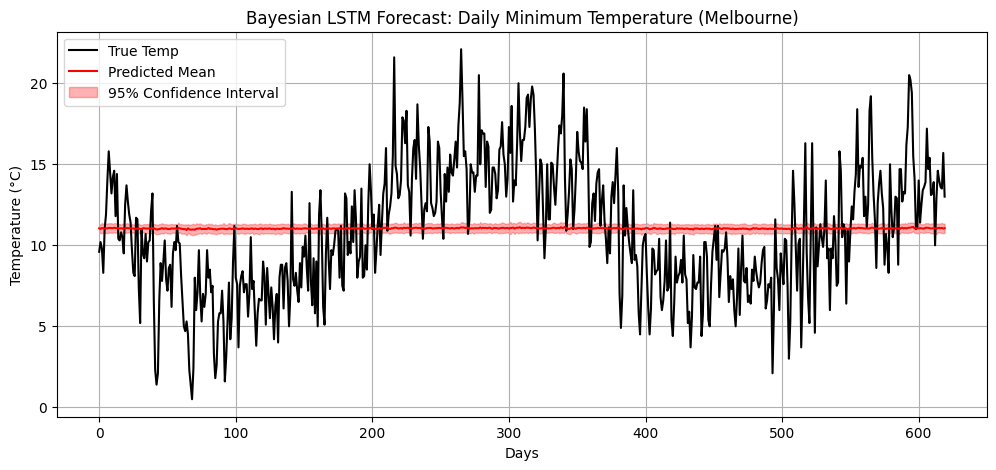

In [14]:
# Fix the true_y shape for inverse_transform
true_y = scaler.inverse_transform(test_y.numpy().reshape(-1, 1))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(true_y, label="True Temp", color="black")
plt.plot(mean_rescaled, label="Predicted Mean", color="red")
plt.fill_between(np.arange(len(std_rescaled)),
                 mean_rescaled[:,0] - 2*std_rescaled[:,0],
                 mean_rescaled[:,0] + 2*std_rescaled[:,0],
                 color='red', alpha=0.3, label="95% Confidence Interval")
plt.title("Bayesian LSTM Forecast: Daily Minimum Temperature (Melbourne)")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()